In [166]:
#Utilizada no Pipeline

import os
import tarfile
from six.moves import urllib
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()
import matplotlib
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    #x = pd.read_csv(csv_path)
    return pd.read_csv(csv_path)#x.drop("total_bedrooms", axis=1)
housing = load_housing_data()
housing.info()
print("OK")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
OK


In [167]:

#Converte a Feature ocean proximity in 5 novas Features Binárias para cada uma de suas características
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
class BinarizeAttributes():
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return self.fit_transform
    def fit_transform(self, X, y=None):
        try:
            s = pd.Series(X["ocean_proximity"], dtype="category")
            categories = s.cat.categories
            data = X.join(pd.DataFrame(LabelBinarizer().fit_transform(X["ocean_proximity"]),index=X.index))
            return data.drop("ocean_proximity", axis=1)
        except:
            return X
print("OK")

OK


In [168]:
###Original 2
##Imputer completa as features incompletas com a mediana #nesse caso
#from sklearn.preprocessing import Imputer
#imputer = Imputer(strategy="median")
#housing = housing.drop("ocean_proximity", axis=1)
#imputer.fit(housing)
#X = imputer.transform(housing)
#housing_tr = pd.DataFrame(X, columns=housing.columns)
#print("OK")

In [169]:
#Utilizada no Pipeline para Separar os dados(teste e treino) com base no atributo media_income
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
class StratDataTrain():
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return self.fit_transform
    def fit_transform(self, X, y=None):
        X["income_cat"] = np.ceil((X["median_income"])/1.5)
        X["income_cat"].where(X["income_cat"] < 5, 5.0, inplace=True)
        
        split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        for train_index, test_index in split.split(X, X["income_cat"]):
            strat_train_set = X.loc[train_index]
            strat_test_set = X.loc[test_index]
        for set_ in (strat_train_set, strat_test_set):
            set_.drop("income_cat", axis=1, inplace=True)
        return strat_train_set.drop("median_house_value", axis=1)
    
#Utilizada no Pipeline para Separar os dados (teste e treino) porém não viesada
class StratDataTest():
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return self.fit_transform
    def fit_transform(self, X, y=None):
        temp = X.drop("median_house_value", axis=1)
        return temp#.drop("income_cat", axis=1)
        
print("OK")

OK


In [170]:
#Utilizada no Pipeline

###Convertendo features em features mais significativas
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
attr_adder.fit(housing.values)
x = attr_adder.transform(housing.values)
print("OK")

OK


In [171]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import LabelBinarizer 
#Pipeline para ser usado com classificação
num_pipeline = Pipeline([
    ('labels_binarize', BinarizeAttributes()),
    ('strat', StratDataTrain()),
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),])

#Pipeline para ser usado sem classificação
num_pipeline_no_strat = Pipeline([
    ('labels_binarize', BinarizeAttributes()),
    ('strat', StratDataTest()),
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),])
print("OK")

OK


In [172]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
#train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

def avaliar(test, classfier):
    housing = load_housing_data()
    housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
    housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(housing, housing["income_cat"]):
        strat_train_set = housing.loc[train_index]
        strat_test_set = housing.loc[test_index]

    for set_ in (strat_train_set, strat_test_set):
        set_.drop("income_cat", axis=1, inplace=True)
    train_set = strat_train_set.drop("median_house_value", axis=1)
    train_set_labels = strat_train_set["median_house_value"].copy()

    test_set = strat_test_set#.drop("income_cat", axis=1)
    test_set_labels = strat_test_set["median_house_value"].copy()

    if(test==1):
        if(classfier==1):
            housingX = num_pipeline.fit_transform(load_housing_data())
            housingY = train_set_labels
            
            housing_testX = num_pipeline_no_strat.fit_transform(test_set)
            housing_testY = test_set_labels
        else:
            train_set, test_set = train_test_split(load_housing_data(), test_size=0.2, random_state=42)
            train_set_labels = train_set["median_house_value"].copy()
            test_set_labels = test_set["median_house_value"].copy()
            
            housingX = num_pipeline_no_strat.fit_transform(train_set)
            housingY = train_set_labels

            housing_testX = num_pipeline_no_strat.fit_transform(test_set)
            housing_testY = test_set_labels
        
    else:
        if(classfier==1):
            housingX = num_pipeline.fit_transform(load_housing_data())
            #train_set, test_set = train_test_split(load_housing_data(), test_size=0.2, random_state=42)
            housingY = train_set_labels
        else:
            train_set, test_set = train_test_split(load_housing_data(), test_size=0.2, random_state=42)
            train_set_labels = train_set["median_house_value"].copy()
            test_set_labels = test_set["median_house_value"].copy()
            
            housingX = num_pipeline_no_strat.fit_transform(train_set)
            housingY = train_set_labels
        #housingX = num_pipeline.fit_transform(load_housing_data())
        #housingY = train_set_labels
        housing_testX = housingX
        housing_testY = housingY
    

    lin_reg = LinearRegression()
    lin_reg.fit(housingX, housingY)
    housing_predictions = lin_reg.predict(housing_testX)
    lin_mse = mean_squared_error(housing_testY, housing_predictions)
    lin_rmse = np.sqrt(lin_mse)
    #lin_rmse

    tree_reg = DecisionTreeRegressor()
    tree_reg.fit(housingX, housingY)
    housing_predictions = tree_reg.predict(housing_testX)
    tree_mse = mean_squared_error(housing_testY, housing_predictions)
    tree_rmse = np.sqrt(tree_mse)
    #tree_rmse

    rf = RandomForestRegressor()
    rf.fit(housingX, housingY)
    housing_predictions = rf.predict(housing_testX)
    rf_mse = mean_squared_error(housing_testY, housing_predictions)
    rf_rmse = np.sqrt(rf_mse)
    #rf_rmse
    return [lin_rmse, tree_rmse, rf_rmse]
print("OK")

OK


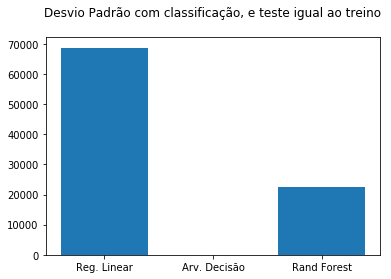

Desvios padrão:
Reg. Linear	 68700.1
Arv. Decisão	 0.0
Rand Forest	 22533.8


In [173]:

eixox = np.arange(3)
eixoy = avaliar(0,1)
%matplotlib inline 

def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1f' % (x * 1e-4)
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
#formatter = FuncFormatter(millions)###BATSA REMOVER ESTE
fig, ax = plt.subplots()
#ax.yaxis.set_major_formatter(formatter)
plt.bar(eixox, eixoy)
plt.xticks(eixox, ('Reg. Linear', 'Arv. Decisão', 'Rand Forest'))
plt.title("Desvio Padrão com classificação, e teste igual ao treino\n")
plt.show()

print("Desvios padrão:")
print('Reg. Linear\t %1.1f' % (eixoy[0]))
print('Arv. Decisão\t %1.1f' % (eixoy[1]))
print('Rand Forest\t %1.1f' % (eixoy[2]))

Desvio Padrão com classificação e teste diferente do treino


<Figure size 432x288 with 0 Axes>

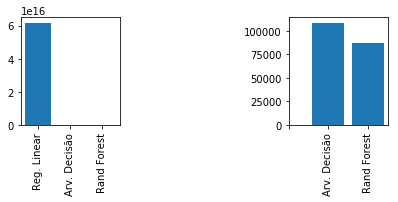

Desvios padrão:
Reg. Linear	 61889222806062024.0
Arv. Decisão	 108802.7
Rand Forest	 86716.7


In [174]:
eixox = np.arange(3)
eixoy = avaliar(1, 1)
%matplotlib inline 

def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1f' % (x * 1e-4)
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
#formatter = FuncFormatter(millions)###BATSA REMOVER ESTE
plt.figure(1)
fig, ax = plt.subplots()
#ax.yaxis.set_major_formatter(formatter)
plt.subplot(231)
plt.bar(eixox, eixoy)
plt.xticks(eixox, ('Reg. Linear', 'Arv. Decisão', 'Rand Forest'), rotation='vertical')
#plt.title("Desvio Padrão c/ classificação c/ teste != treino")

plt.subplot(233)
plt.bar(eixox[1:], eixoy[1:])
plt.xticks(eixox, (' ','Arv. Decisão', 'Rand Forest'), rotation='vertical')
#plt.title("Desvio Padrão c/ classificação c/ teste != treino")
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
print("Desvio Padrão com classificação e teste diferente do treino")
plt.show()

print("Desvios padrão:")
print('Reg. Linear\t %1.1f' % (eixoy[0]))
print('Arv. Decisão\t %1.1f' % (eixoy[1]))
print('Rand Forest\t %1.1f' % (eixoy[2]))

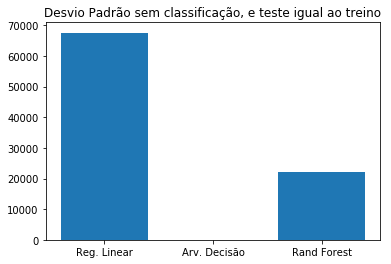

Desvios padrão:
Reg. Linear	 67593.2
Arv. Decisão	 0.0
Rand Forest	 22274.6


In [175]:

eixox = np.arange(3)
eixoy = avaliar(0,0)
%matplotlib inline 

def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1f' % (x * 1e-4)
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
#formatter = FuncFormatter(millions)###BATSA REMOVER ESTE
fig, ax = plt.subplots()
#ax.yaxis.set_major_formatter(formatter)
plt.bar(eixox, eixoy)
plt.xticks(eixox, ('Reg. Linear', 'Arv. Decisão', 'Rand Forest'))
plt.title("Desvio Padrão sem classificação, e teste igual ao treino")
plt.show()

print("Desvios padrão:")
print('Reg. Linear\t %1.1f' % (eixoy[0]))
print('Arv. Decisão\t %1.1f' % (eixoy[1]))
print('Rand Forest\t %1.1f' % (eixoy[2]))

Desvio Padrão sem classificação, e teste diferente do treino


<Figure size 432x288 with 0 Axes>

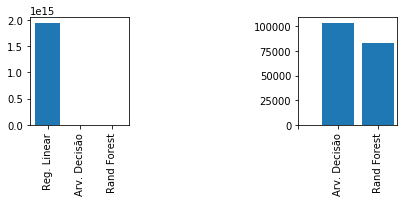

Desvios padrão:
Reg. Linear	 1950151539100287.2
Arv. Decisão	 103967.9
Rand Forest	 82873.1


In [176]:
eixox = np.arange(3)
eixoy = avaliar(1, 0)
%matplotlib inline 

def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1f' % (x * 1e-4)
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
#formatter = FuncFormatter(millions)###BATSA REMOVER ESTE
plt.figure(1)
fig, ax = plt.subplots()
#ax.yaxis.set_major_formatter(formatter)
plt.subplot(231)
plt.bar(eixox, eixoy)
plt.xticks(eixox, ('Reg. Linear', 'Arv. Decisão', 'Rand Forest'), rotation='vertical')
#plt.title("Desvio Padrão c/ classificação c/ teste != treino")

plt.subplot(233)
plt.bar(eixox[1:], eixoy[1:])
plt.xticks(eixox, (' ','Arv. Decisão', 'Rand Forest'), rotation='vertical')
#plt.title("Desvio Padrão c/ classificação c/ teste != treino")
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
print("Desvio Padrão sem classificação, e teste diferente do treino")
plt.show()

print("Desvios padrão:")
print('Reg. Linear\t %1.1f' % (eixoy[0]))
print('Arv. Decisão\t %1.1f' % (eixoy[1]))
print('Rand Forest\t %1.1f' % (eixoy[2]))